In [1]:
# Make sure we can import EMQST_lib from parent directory
import sys
from pathlib import Path

# Go two levels up from current working directory
PROJECT_ROOT = Path.cwd().resolve().parents[1]   # <- one up (your earlier case)


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Using project root:", PROJECT_ROOT)

# Notebook is in project-root/Multiplexed_qubit_readout_results/
# -> project root is the parent of the current working dir
PROJECT_ROOT = Path.cwd().resolve().parent


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import numpy as np 
from datetime import datetime
import os
import uuid
import glob
from EMQST_lib import adaptive_functions as ad
from EMQST_lib.qst import QST  
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import support_functions as sf
from EMQST_lib.povm import POVM
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from EMQST_lib.visualization import power_law
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.autolayout"] = True
cmap        = colormaps['Dark2']
box_props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.5)
%load_ext autoreload
%autoreload 2

one_qubit_adaptive_inf_con = []
one_qubit_nonadaptive_inf_con = []

load_path = 'adaptive_results/one_qubit_100k' #two_qubit_longtest'
glob_path = os.path.join(load_path, '*.npy')
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(load_path, "*")) if os.path.isdir(f)]
print(f'Found {len(folders)} folders')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        one_qubit_setting_array = np.load(f, allow_pickle=True)
    one_qubit_adaptive_inf_con.append(infidelity_dict['adaptive_infidelity_container'])
    one_qubit_nonadaptive_inf_con.append(infidelity_dict['nonadaptive_infidelity_container'])
one_qubit_noise_strengths = one_qubit_setting_array[0]['noise_strengths']



Using project root: /workspaces/REMQST
Found 41 folders
Folder 0: adaptive_results/one_qubit_100k/2025-10-17_23-32-05_31a2ced7-9c12-40d8-bb62-a28cc6d7138c
Folder 1: adaptive_results/one_qubit_100k/2025-10-17_23-32-05_58b08872-81b5-4358-af40-d8460c018392
Folder 2: adaptive_results/one_qubit_100k/2025-10-17_23-32-05_78d72a60-21f4-4d30-bc38-033ac8c314ea
Folder 3: adaptive_results/one_qubit_100k/2025-10-19_17-28-22_9ac673a0-a247-4f7a-8b8f-f9901e0a66cf
Folder 4: adaptive_results/one_qubit_100k/2025-10-19_18-02-53_8174d289-5c9e-43ec-b512-7ab1a7de798f
Folder 5: adaptive_results/one_qubit_100k/2025-10-19_18-37-55_834a5b7b-7fc6-409f-b299-a912fe8e8a66
Folder 6: adaptive_results/one_qubit_100k/2025-10-19_19-13-58_eb6f04a5-d426-4c72-8d73-78ad6f171ca3
Folder 7: adaptive_results/one_qubit_100k/2025-10-19_19-15-44_d6cc716b-1a10-498e-99e9-c81bbb023ae5
Folder 8: adaptive_results/one_qubit_100k/2025-10-19_19-15-44_e14a35d5-2f5e-48cc-aeba-04829e472bf9
Folder 9: adaptive_results/one_qubit_100k/2025-10-19_

## Infidelity threshold

50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025
50 100000
Adaptive counts: 1025, Non-adaptive counts: 1025


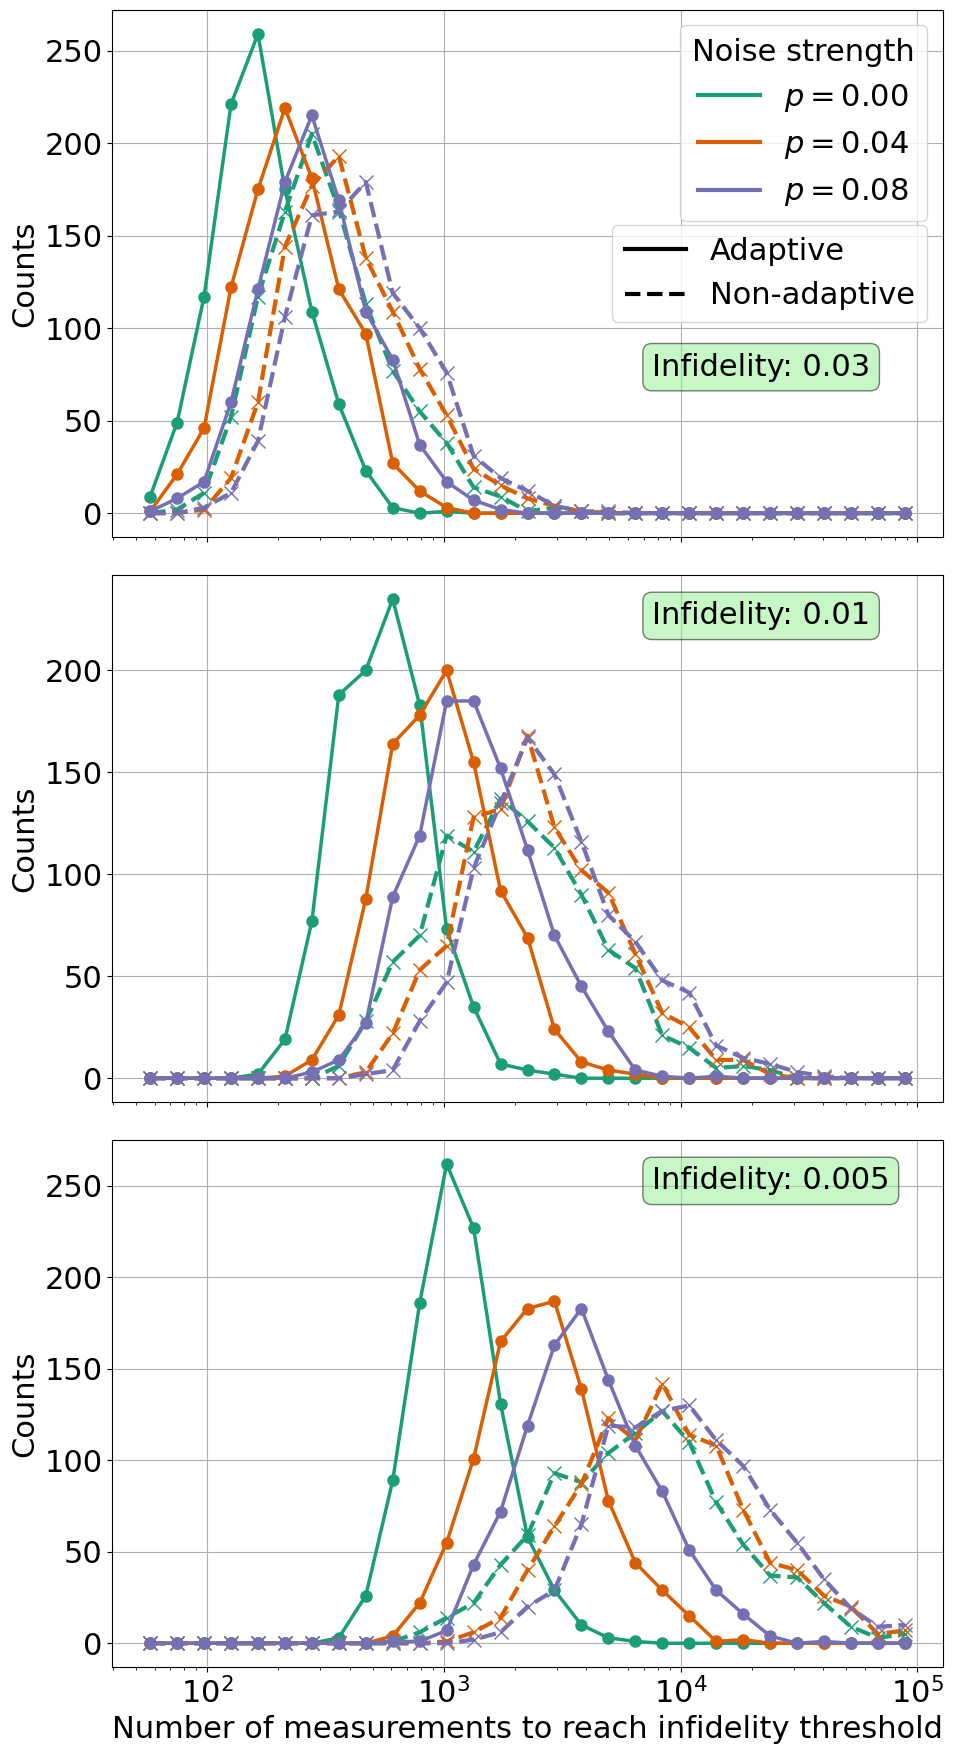

In [51]:
def find_infidelity_cross_array(threshold_value, inf_container):
    # Containers has [#separate_fils, #err_runs, #N_averages, #N_shots ]
    shape = np.shape(inf_container)
    reshaped_container = np.einsum('ijkl->jikl', inf_container)
    combined_container = np.reshape(reshaped_container, (shape[0], -1, shape[-1]))
    #print(np.shape(combined_container))
    full_cross_array = []
    for container in combined_container:
        cross_array = []
        for run in container:
            arg_crosses = np.argwhere(run < threshold_value)
            if len(arg_crosses) > 0:
                cross_array.append([arg_crosses[0][0]])
            else:   
                cross_array.append([len(run)]) # If it never crosses the threshold, we set it to infinity.
        full_cross_array.append(cross_array)
    return np.reshape(full_cross_array, (shape[1], -1))


# --- color map keyed by noise strength ---
color_map   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued
threshold_values = [0.03, 0.01,0.005]


fig,axes = plt.subplots(len(threshold_values),1, figsize=(10,6*len(threshold_values)), sharex=True)
for i, ax in enumerate(axes):
    ada_cross_array = find_infidelity_cross_array(threshold_values[i], one_qubit_adaptive_inf_con)[:-1]
    noada_cross_array = find_infidelity_cross_array(threshold_values[i], one_qubit_nonadaptive_inf_con)[:-1]
    for noise_index in range(len(ada_cross_array)):
        #combined_array = np.concatenate((ada_cross_array, noada_cross_array), axis=0)
        min_value = 50#np.min(ada_cross_array)
        max_value = 10**5#np.max(noada_cross_array)
        print(min_value, max_value)
        steps = 30
        levels = np.logspace(np.log10(min_value), np.log10(max_value), steps)   


        # --- if your find_corss_array returns 1-element arrays, make sure rows are scalars ---
        def _row_to_1d_int(arr_row):
            """Safely flatten a possibly ragged row of 1-element arrays into ints."""
            # e.g. arr_row could look like [array([12]), array([7]), ...]
            flat = [int(np.ravel(x)[0]) for x in arr_row]
            return np.asarray(flat)

        # Take the first row from each cross array and coerce to 1D ints
        ada_vals = _row_to_1d_int(ada_cross_array[noise_index])
        noada_vals = _row_to_1d_int(noada_cross_array[noise_index])

        # Use your 'levels' as bin edges
        bin_edges = np.asarray(levels)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Histograms over the provided bins
        ada_counts, _   = np.histogram(ada_vals, bins=bin_edges)
        noada_counts, _ = np.histogram(noada_vals, bins=bin_edges)

        print(f'Adaptive counts: {np.sum(ada_counts)}, Non-adaptive counts: {np.sum(noada_counts)}')
        # Plot as curves over the discrete bins

        ax.plot(bin_centers, ada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_ada, marker='o', markersize=ada_markersize, linestyle='-', label=f'Adaptive {threshold_values[i]}')
        ax.plot(bin_centers, noada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_nonada, marker='x', markersize=nonada_markersize, linestyle='--', label=f'Non-adaptive {threshold_values[i]}')
        ax.set_xscale('log')
        ax.set_ylabel('Counts')
        ax.grid(True, alpha=1)





# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
color_handles = [Line2D([0], [0], color=color_map[p], lw=3, label=rf'$p={p:.2f}$')
                 for i, p in enumerate(one_qubit_noise_strengths[:-1])]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive')
]

leg1 = axes[0].legend(handles=color_handles, title='Noise strength', loc='upper right', frameon=True)
axes[0].add_artist(leg1)  # add the first legend manually
axes[0].legend(handles=style_handles, loc='center right', frameon=True) # keep first legend when adding the second
#plt.legend(handles=style_handles, loc='upper right', frameon=True)

axes[2].set_xlabel('Number of measurements to reach infidelity threshold')


axes[0].text(0.65, 0.35, fr'Infidelity: {threshold_values[0]}', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[1].text(0.65, 0.95, fr'Infidelity: {threshold_values[1]}', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[2].text(0.65, 0.95, fr'Infidelity: {threshold_values[2]}', transform=axes[2].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
fig.savefig("Images/Shots_to_reach_infidelity.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()



## Shot threshold

Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025
Adaptive counts: 1025, Non-adaptive counts: 1025


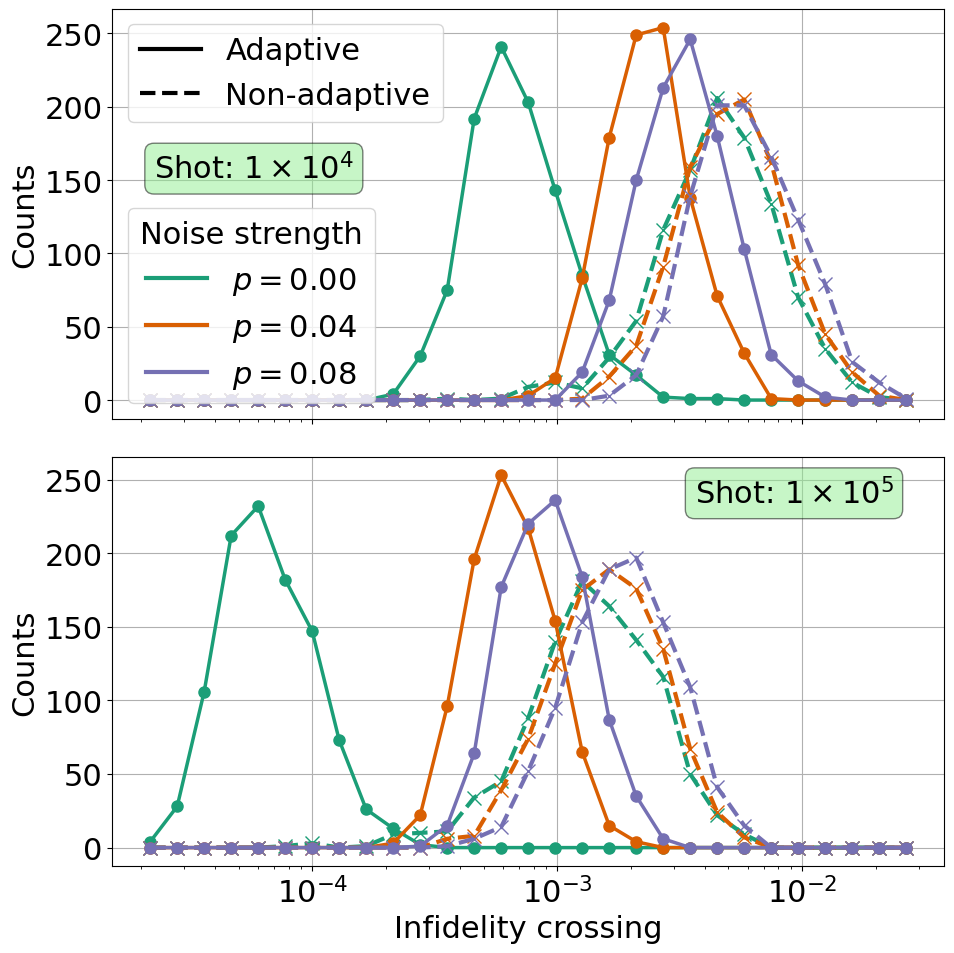

In [52]:
def find_shot_cross_array(shot_value, inf_container):
    # Containers has [#separate_fils, #err_runs, #N_averages, #N_shots ]
    shape = np.shape(inf_container)
    reshaped_container = np.einsum('ijkl->jikl', inf_container)
    combined_container = np.reshape(reshaped_container, (shape[0], -1, shape[-1]))
    #print(np.shape(combined_container))
    full_cross_array = []
    for container in combined_container:
        cross_array = []
        for run in container:
            cross_array.append(run[shot_value])
        full_cross_array.append(cross_array)
    return np.reshape(full_cross_array, (shape[1], -1))


# --- color map keyed by noise strength ---
color_map   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}
# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
lw_fit      = 3.0
ada_markersize = 8
nonada_markersize = 10
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued


shot_values = [10000,99998]
fig,axes=plt.subplots(2,1,figsize=(10,10),sharex=True)

#print(ada_cross_array)

for i,ax in enumerate(axes):
    shot_value = shot_values[i]
    ada_cross_array = find_shot_cross_array(shot_values[i], one_qubit_adaptive_inf_con)[:-1]
    noada_cross_array = find_shot_cross_array(shot_values[i], one_qubit_nonadaptive_inf_con)[:-1]
    for noise_index in range(len(ada_cross_array)):
        #combined_array = np.concatenate((ada_cross_array, noada_cross_array), axis=0)
        min_value = 1.9e-05 #np.min(ada_cross_array)
        max_value = 0.03#np.max(noada_cross_array)
        #print(min_value, max_value)
        steps = 30
        levels = np.logspace(np.log10(min_value), np.log10(max_value), steps)

        #print(levels)
        # --- if your find_corss_array returns 1-element arrays, make sure rows are scalars ---
        def _row_to_1d_int(arr_row):
            """Safely flatten a possibly ragged row of 1-element arrays into ints."""
            # e.g. arr_row could look like [array([12]), array([7]), ...]
            flat = [np.ravel(x)[0] for x in arr_row]
            return np.asarray(flat)

        # Take the first row from each cross array and coerce to 1D ints
        ada_vals = _row_to_1d_int(ada_cross_array[noise_index])
        noada_vals = _row_to_1d_int(noada_cross_array[noise_index])

        # Use your 'levels' as bin edges
        bin_edges = np.asarray(levels)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        #print(bin_centers)
        # Histograms over the provided bins
        ada_counts, _   = np.histogram(ada_vals, bins=bin_edges)
        noada_counts, _ = np.histogram(noada_vals, bins=bin_edges)
        #print(ada_counts)
        print(f'Adaptive counts: {np.sum(ada_counts)}, Non-adaptive counts: {np.sum(noada_counts)}')
        # Plot as curves over the discrete bins

        ax.plot(bin_centers, ada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_ada, marker='o', markersize=ada_markersize, linestyle='-', label=f'Adaptive {shot_value}')
        ax.plot(bin_centers, noada_counts, color=color_map[one_qubit_noise_strengths[noise_index]], linewidth=lw_nonada, marker='x', markersize=nonada_markersize, linestyle='--', label=f'Non-adaptive {shot_value}')
        ax.set_xscale('log')
        ax.set_ylabel('Counts')
        ax.grid(True, alpha=0.3)




# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
color_handles = [Line2D([0], [0], color=color_map[p], lw=3, label=rf'$p={p:.2f}$')
                 for i, p in enumerate(one_qubit_noise_strengths[:-1])]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive')
]

leg1 = axes[0].legend(handles=color_handles, title='Noise strength',loc='lower left', frameon=True)
axes[0].add_artist(leg1)  # keep first legend when adding the second
 # keep first legend when adding the second
axes[0].grid(True, alpha=1)
axes[1].grid(True, alpha=1)
axes[0].legend(handles=style_handles, loc='upper left', frameon=True)

axes[1].set_xlabel('Infidelity crossing')
# def sci_notation_latex(n, precision=0):
#     # Convert to scientific notation string
#     s = f"{n:.{precision}e}"
#     base, exp = s.split("e")
#     exp = int(exp)
#     return f"{base} \\times 10^{{{exp}}}"
axes[0].text(0.05, 0.65, fr'Shot: $1 \times 10^4$', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[1].text(0.7, 0.95, fr'Shot: $1 \times 10^5$', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
fig.savefig("Images/Infidelity_at_shot_threshold.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


## Full infidelity plot

Found 5 folders
Folder 0: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_131e5527-6f95-4cfd-a023-0991a3162e95
Folder 1: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_9c048acb-536d-4b64-ac8e-70795d38c4e2
Folder 2: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_9ebbad1f-9e56-4cf0-9d37-b83c3aa23a9c
Folder 3: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_c018184c-54f1-4199-9446-f66f54a8222d
Folder 4: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-30_c177b46d-8ee4-4e7f-8cc8-908d7176c505
(4, 99999)
(5, 4, 5, 99999)
Size of one qubit exponents: 1025, two qubit exponents: 25


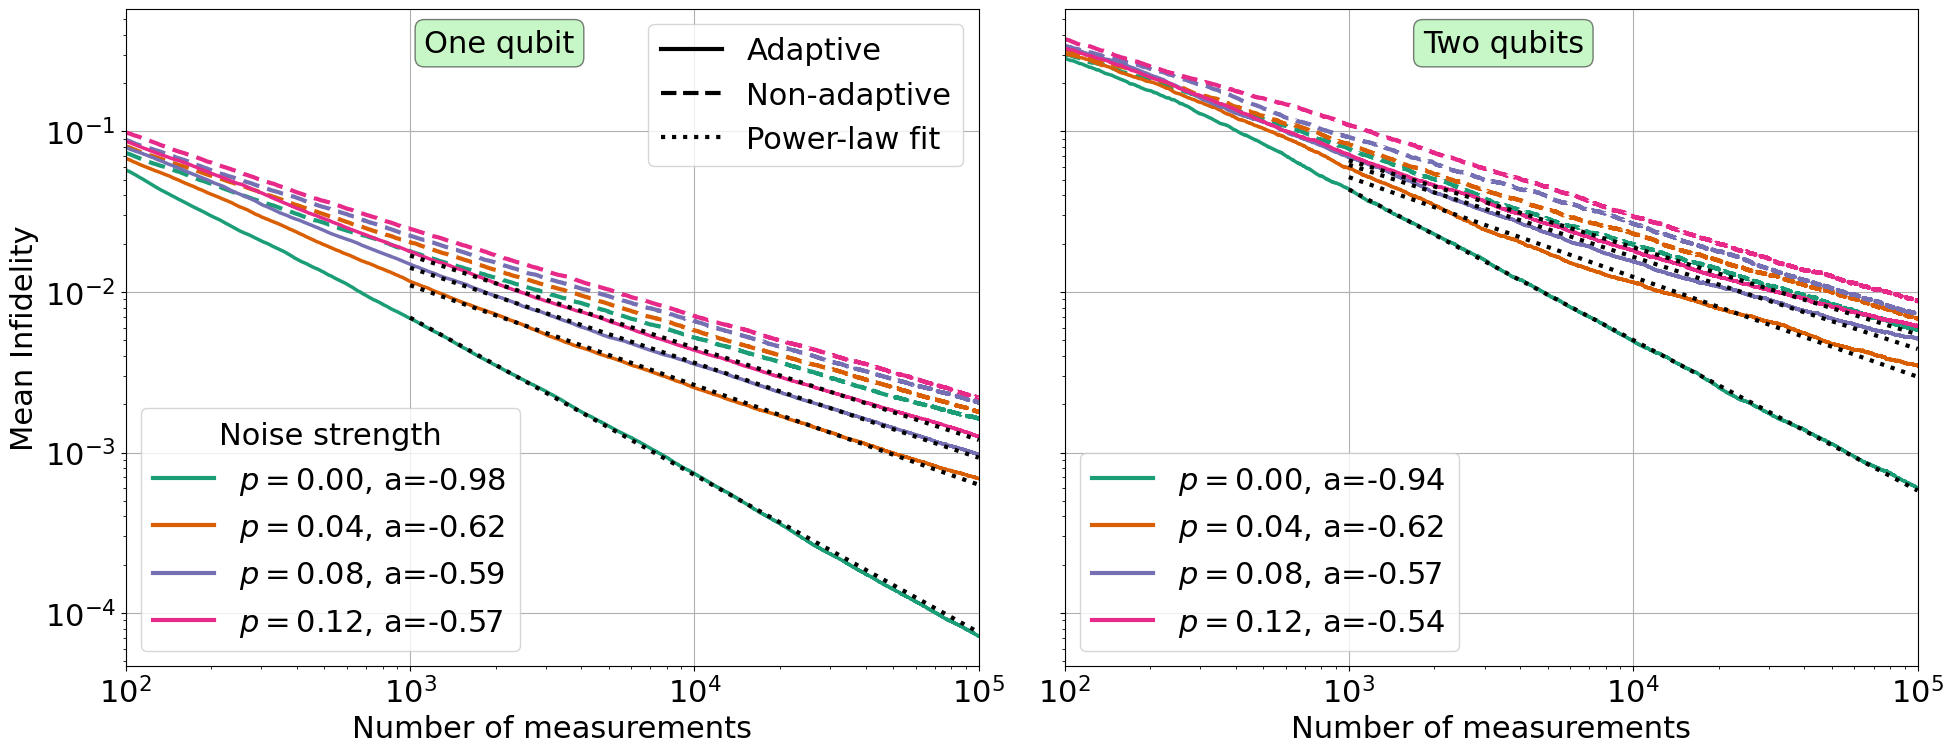

In [3]:
one_qubit_settings = one_qubit_setting_array[0]
adaptive_burnin = one_qubit_settings['adaptive_burnin']
one_qubit_noise_strengths = one_qubit_settings['noise_strengths']

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Expect shape: (n_sheets, n_strengths, n_averages, n_points)
mean_one_qubit_ada   = np.mean(one_qubit_adaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)
mean_one_qubit_nonade  = np.mean(one_qubit_nonadaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)

# X-axes (allow different lengths just in case)
x_one_qubit   = np.arange(np.shape(one_qubit_adaptive_inf_con)[-1])

adaptive_exponent_fit = []
cutoff     = 100
fitcutoff  = 1000  # fit only after twice the burn-in

# --- color map keyed by noise strength ---

color_map_one_qubit   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}

# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued

# --- loop over noise strengths and plot both methods + fits ---
# inside your loop over noise_strengths
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]

    # Plot adaptive (solid)
    line_ad, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_ada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"Adaptive p={p:.2f}"
    )

    # Plot non-adaptive (dashed) 
    line_non, = axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_nonade[i, cutoff:],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

    # fits (on their own native x after fitcutoff)
    popt_ad,  _ = curve_fit(power_law, x_one_qubit[fitcutoff:],  mean_one_qubit_ada[i,fitcutoff:],  p0=np.array([1.0, -0.5]))
    popt_non, _ = curve_fit(power_law, x_one_qubit[fitcutoff:], mean_one_qubit_nonade[i,fitcutoff:], p0=np.array([1.0, -0.5]))
    adaptive_exponent_fit.append(popt_ad[1])

    axes[0].plot(x_one_qubit[fitcutoff:],  power_law(x_one_qubit[fitcutoff:],  *popt_ad),
            fit_style, color='k', linewidth=lw_fit)
    #ax.plot(x_non[fitcutoff:], power_law(x_non[fitcutoff:], *popt_non),
    #        fit_style, color='k', linewidth=lw_fit)

# burn-in marker
#axes[0].axvline(x=adaptive_burnin, color='black', linestyle='--', linewidth=2)
#axes[0].axhline(y=0.01, color='gray', linestyle=':', linewidth=2)
# axes formatting
axes[0].text(0.35, 0.97, 'One qubit', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
axes[0].set_xlabel('Number of measurements')
axes[0].set_ylabel('Mean Infidelity')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(cutoff, x_one_qubit[-1]+3)
axes[0].grid(True, alpha=1)


# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
one_qubit_color_handles = [Line2D([0], [0], color=color_map_one_qubit[p], lw=3, label=rf'$p={p:.2f}$, a={scale:.2f} ')
                 for p, scale in zip(one_qubit_noise_strengths, adaptive_exponent_fit)]

style_handles = [
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['adaptive'],     label='Adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=linestyles['non-adaptive'], label='Non-adaptive'),
    Line2D([0], [0], color='k', lw=3, linestyle=fit_style,                   label='Power-law fit')
]

leg1 = axes[0].legend(handles=one_qubit_color_handles, title='Noise strength', loc='lower left', frameon=True)
axes[0].add_artist(leg1)  # keep first legend when adding the second
axes[0].legend(handles=style_handles, loc='upper right', frameon=True)



# Two qubit plot
two_qubit_path = 'adaptive_results/two_qubit_100k_new_param'
glob_path = os.path.join(two_qubit_path, '*.npy')

two_qubit_adaptive_container = []
two_qubit_nonadaptive_container = []
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(two_qubit_path, "*")) if os.path.isdir(f)]
print(f'Found {len(folders)} folders')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        two_qubit_setting_array = np.load(f, allow_pickle=True)
    two_qubit_adaptive_container.append(infidelity_dict['adaptive_infidelity_container'])
    two_qubit_nonadaptive_container.append(infidelity_dict['nonadaptive_infidelity_container'])
two_qubit_noise_strengths = two_qubit_setting_array[0]['noise_strengths']


# --- color map keyed by noise strength ---
color_map_two_qubit   = {p: cmap(i) for i, p in enumerate(two_qubit_noise_strengths)}
# Compute means
mean_two_qubit_ada = np.mean(two_qubit_adaptive_container, axis=(0, 2))
mean_two_qubit_nonada = np.mean(two_qubit_nonadaptive_container, axis=(0, 2))
print(np.shape(mean_two_qubit_ada))
x_two_qubit = np.arange(np.shape(two_qubit_adaptive_container)[-1])
two_qubit_adaptive_exponent_fit = []
# Plotting
for i, p in enumerate(two_qubit_noise_strengths):
    color = color_map_two_qubit[p]

    # Plot adaptive (solid)
    line_ad, = axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_ada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"p={p:.2f}"
    )

    # Plot non-adaptive (dashed) 
    line_non, = axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_nonada[i, cutoff:],
        linestyle='--', color=color, linewidth=lw_nonada
    )
    line_non.set_dashes([4, 2])  # 8 points on, 4 off — consistent on log scale

    # fits (on their own native x after fitcutoff)
    popt_ad,  _ = curve_fit(power_law, x_two_qubit[fitcutoff:],  mean_two_qubit_ada[i,fitcutoff:],  p0=np.array([1.0, -0.5]))
    popt_non, _ = curve_fit(power_law, x_two_qubit[fitcutoff:], mean_two_qubit_nonada[i,fitcutoff:], p0=np.array([1.0, -0.5]))
    two_qubit_adaptive_exponent_fit.append(popt_ad[1])

    axes[1].plot(x_two_qubit[fitcutoff:],  power_law(x_two_qubit[fitcutoff:],  *popt_ad),
            fit_style, color='k', linewidth=lw_fit)

# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
two_qubit_color_handles = [Line2D([0], [0], color=color_map_two_qubit[p], lw=3, label=rf'$p={p:.2f}$, a={scale:.2f} ')
                 for p, scale in zip(two_qubit_noise_strengths, two_qubit_adaptive_exponent_fit)]


axes[1].legend(handles=two_qubit_color_handles, loc='lower left', frameon=True)
axes[1].text(0.42, 0.97, 'Two qubits', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)

axes[1].set_xlabel('Number of measurements')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(cutoff, x_two_qubit[-1]+3)
axes[1].grid(True, alpha=1)



one_qubit_size = np.shape(one_qubit_adaptive_inf_con)
two_qubit_size = np.shape(two_qubit_adaptive_container)
print(two_qubit_size)
print(f'Size of one qubit exponents: {one_qubit_size[0]*one_qubit_size[2]}, two qubit exponents: {two_qubit_size[0]*two_qubit_size[2]}')

#axes[1].legend()
fig.savefig("Images/Infidelity_comparison.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


## Adaptive relative improvment factor

Found 5 folders
Folder 0: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_131e5527-6f95-4cfd-a023-0991a3162e95
Folder 1: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_9c048acb-536d-4b64-ac8e-70795d38c4e2
Folder 2: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_9ebbad1f-9e56-4cf0-9d37-b83c3aa23a9c
Folder 3: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-24_c018184c-54f1-4199-9446-f66f54a8222d
Folder 4: adaptive_results/two_qubit_100k_new_param/2025-10-23_15-55-30_c177b46d-8ee4-4e7f-8cc8-908d7176c505
(4, 99999)
Size of one qubit exponents: 1025, two qubit exponents: 25


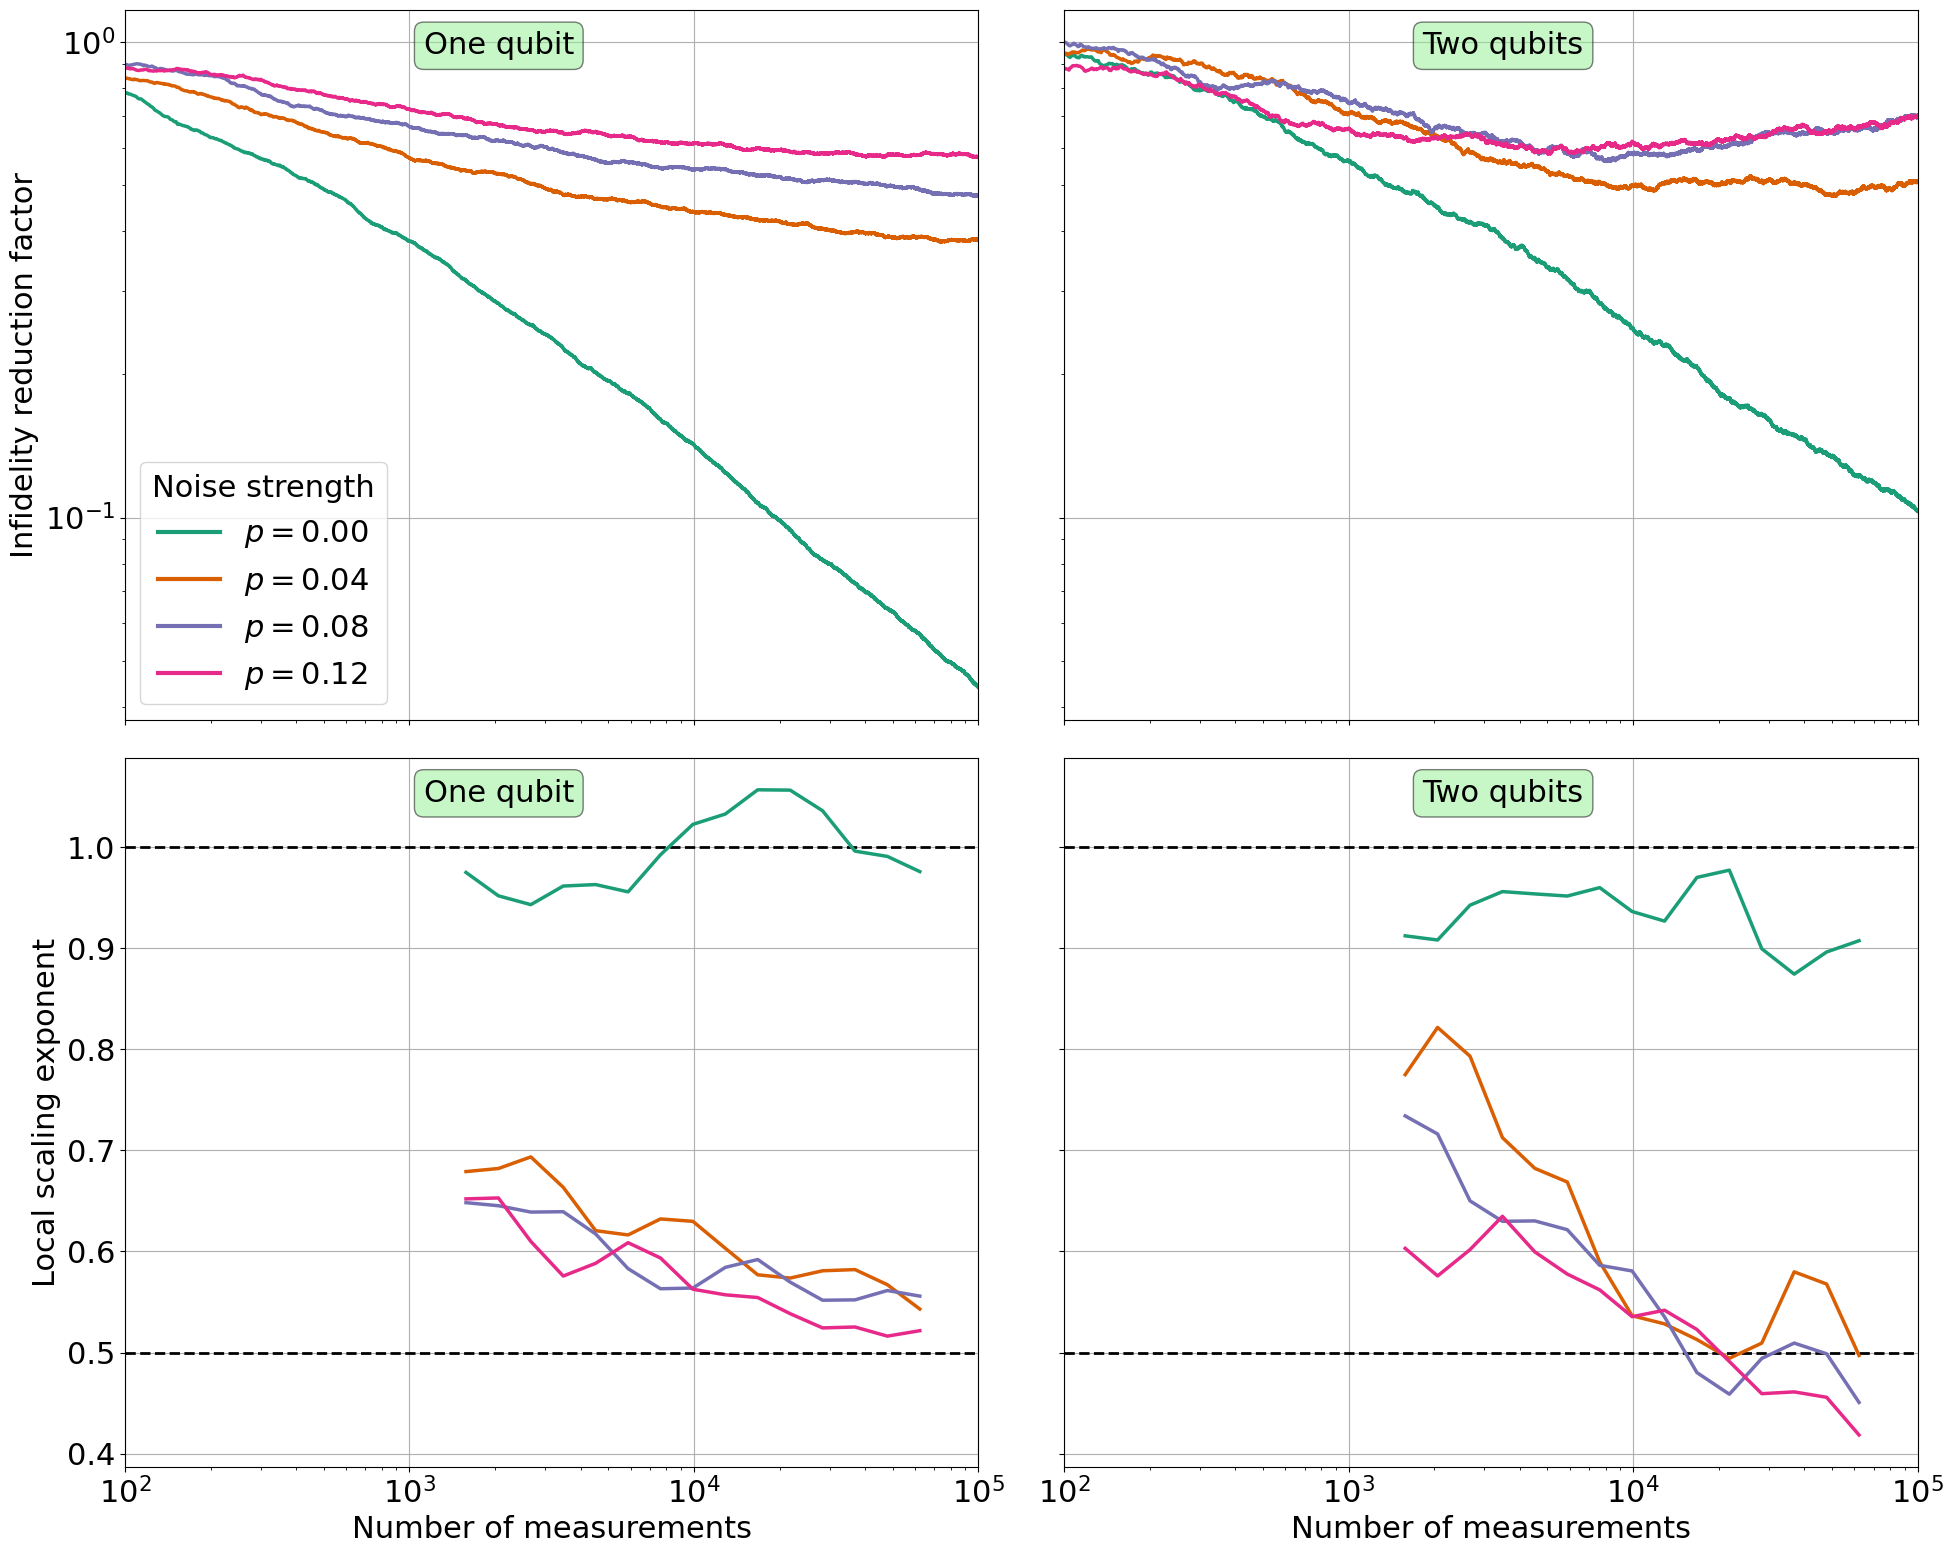

In [6]:
one_qubit_settings = one_qubit_setting_array[0]
adaptive_burnin = one_qubit_settings['adaptive_burnin']
one_qubit_noise_strengths = one_qubit_settings['noise_strengths']

fig, axes4 = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(20, 16))
axes = axes4.flatten()
# Expect shape: (n_sheets, n_strengths, n_averages, n_points)
mean_one_qubit_ada   = np.mean(one_qubit_adaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)
mean_one_qubit_nonade  = np.mean(one_qubit_nonadaptive_inf_con, axis=(0,2))   # (n_strenghts, n_points,)

# X-axes (allow different lengths just in case)
x_one_qubit   = np.arange(np.shape(one_qubit_adaptive_inf_con)[-1])

adaptive_exponent_fit = []
cutoff     = 100
fitcutoff  = 1000  # fit only after twice the burn-in

# --- color map keyed by noise strength ---

color_map_one_qubit   = {p: cmap(i) for i, p in enumerate(one_qubit_noise_strengths)}

# --- styles ---
linestyles  = {'adaptive': '-', 'non-adaptive': '--'}
fit_style   = ':'  # dotted for fits
lw_ada      = 2.5
lw_nonada   = 3.0
ada_markersize = 8
nonada_markersize = 10
lw_fit      = 3.0
alpha_fit   = 0.9  # make 0.9 if you want it slightly subdued

# --- loop over noise strengths and plot both methods + fits ---
# inside your loop over noise_strengths
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]

    # Plot adaptive (solid)
    axes[0].plot(
        x_one_qubit[cutoff:], mean_one_qubit_ada[i, cutoff:]/mean_one_qubit_nonade[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"Adaptive p={p:.2f}"
    )

axes[0].text(0.35, 0.97, 'One qubit', transform=axes[0].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)
#axes[0].set_xlabel('Number of measurements')
axes[0].set_ylabel('Infidelity reduction factor')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(cutoff, x_one_qubit[-1]+3)
axes[0].grid(True, alpha=1)


# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
one_qubit_color_handles = [Line2D([0], [0], color=color_map_one_qubit[p], lw=3, label=rf'$p={p:.2f}$')
                 for p in one_qubit_noise_strengths]

axes[0].legend(handles=one_qubit_color_handles, title='Noise strength', loc='lower left', frameon=True)


# Two qubit plot
two_qubit_path = 'adaptive_results/two_qubit_100k_new_param'
glob_path = os.path.join(two_qubit_path, '*.npy')

two_qubit_adaptive_container = []
two_qubit_nonadaptive_container = []
# Find all folders in subfolder
folders = [f for f in glob.glob(os.path.join(two_qubit_path, "*")) if os.path.isdir(f)]
print(f'Found {len(folders)} folders')
for i, folder in enumerate(folders):
    print(f'Folder {i}: {folder}')
    with open(f'{folder}/infidelity_container.npy', 'rb') as f:
        infidelity_dict = np.load(f, allow_pickle=True).item()
    with open(f'{folder}/settings.npy', 'rb') as f:    
        two_qubit_setting_array = np.load(f, allow_pickle=True)
    two_qubit_adaptive_container.append(infidelity_dict['adaptive_infidelity_container'])
    two_qubit_nonadaptive_container.append(infidelity_dict['nonadaptive_infidelity_container'])
two_qubit_noise_strengths = two_qubit_setting_array[0]['noise_strengths']


# --- color map keyed by noise strength ---
color_map_two_qubit   = {p: cmap(i) for i, p in enumerate(two_qubit_noise_strengths)}
# Compute means
mean_two_qubit_ada = np.mean(two_qubit_adaptive_container, axis=(0, 2))
mean_two_qubit_nonada = np.mean(two_qubit_nonadaptive_container, axis=(0, 2))
print(np.shape(mean_two_qubit_ada))
x_two_qubit = np.arange(np.shape(two_qubit_adaptive_container)[-1])
two_qubit_adaptive_exponent_fit = []
# Plotting
for i, p in enumerate(two_qubit_noise_strengths):
    color = color_map_two_qubit[p]

    # Plot adaptive (solid)
    axes[1].plot(
        x_two_qubit[cutoff:], mean_two_qubit_ada[i, cutoff:]/mean_two_qubit_nonada[i, cutoff:],
        linestyle=linestyles['adaptive'],
        color=color, linewidth=lw_ada,
        label=f"p={p:.2f}"
    )
# --- legends: 1) noise strengths (colors), 2) styles (methods + fit) ---
two_qubit_color_handles = [Line2D([0], [0], color=color_map_two_qubit[p], lw=3, label=rf'$p={p:.2f}$')
                 for p in two_qubit_noise_strengths]


#axes[1].legend(handles=two_qubit_color_handles, loc='lower left', frameon=True)
axes[1].text(0.42, 0.97, 'Two qubits', transform=axes[1].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)

#axes[1].set_xlabel('Number of measurements')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(cutoff, x_two_qubit[-1]+3)
axes[1].grid(True, alpha=1)

print(f'Size of one qubit exponents: {one_qubit_size[0]*one_qubit_size[2]}, two qubit exponents: {two_qubit_size[0]*two_qubit_size[2]}')
    



# Hyperparameters (full-span, log windows)
SPAN = 2.5         # each fit covers [x, SPAN*x]
STEP_FACTOR = 1.3  # overlap between windows
start_one = max(fitcutoff, cutoff)
start_two = max(fitcutoff, cutoff)

# Plotting some guiding lines
axes[2].axhline(y=0.5, color='black', linestyle='--', linewidth=2)
axes[2].axhline(y=1.0, color='black', linestyle='--', linewidth=2)
axes[3].axhline(y=0.5, color='black', linestyle='--', linewidth=2)
axes[3].axhline(y=1.0, color='black', linestyle='--', linewidth=2)


# -------- One qubit (adaptive) --------
for i, p in enumerate(one_qubit_noise_strengths):
    color = color_map_one_qubit[p]
    x_ada, a_ada = exponent_series_curvefit_logspan(
        mean_one_qubit_ada[i], x_one_qubit,
        span=SPAN, step_factor=STEP_FACTOR, start_idx=start_one,
        include_final_window=True
    )
    if a_ada.size:
        axes[2].plot(x_ada, np.abs(a_ada), linestyles['adaptive'], lw=lw_ada, color=color, label=rf'$p={p:.2f}$ (ada)')

axes[2].set_xlabel('Number of measurements')
axes[2].set_ylabel('Local scaling exponent')
axes[2].set_xscale('log')
axes[2].grid(True, alpha=1)
axes[2].text(0.35, 0.97, 'One qubit', transform=axes[2].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)


# -------- Two qubits (adaptive) --------
for i, p in enumerate(two_qubit_noise_strengths):
    color = color_map_two_qubit[p]
    x_ada2, a_ada2 = exponent_series_curvefit_logspan(
        mean_two_qubit_ada[i], x_two_qubit,
        span=SPAN, step_factor=STEP_FACTOR, start_idx=start_two,
        include_final_window=True
    )
    if a_ada2.size:
        axes[3].plot(x_ada2, np.abs(a_ada2), linestyles['adaptive'], lw=lw_ada, color=color, label=rf'$p={p:.2f}$ (ada)')

axes[3].set_xlabel('Number of measurements')
axes[3].set_xscale('log')
axes[3].grid(True, alpha=1)
axes[3].text(0.42, 0.97, 'Two qubits', transform=axes[3].transAxes, fontsize=22,
        verticalalignment='top', bbox=box_props)




fig.savefig("Images/Infidelity_improvment_factor.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()


## Decay of transinet exponential scaling factor

In [5]:
# ============================================
# Local exponent via curve_fit(power_law, ...)
# LOG-SPAN windows with FULL coverage (no edge truncation)
# ============================================

from scipy.optimize import curve_fit
import numpy as np

def exponent_series_curvefit_logspan(
    y, x, span=1.5, step_factor=1.25, start_idx=0,
    p0=(1.0, -0.5), maxfev=10000, min_points=20,
    include_final_window=True
):
    """
    Slide full log windows: for left edge Xl, window is [Xl, Xl*span].
    Only evaluate windows that are COMPLETELY inside the valid data range
    (x>0, y>0, finite). No truncated windows at either end.

    Args:
        y, x: arrays (x must be non-decreasing)
        span (float): multiplicative width (>1), e.g., 3 means 1.0 decade ~0.477
        step_factor (float): multiplicative step between windows (>1)
        start_idx (int): first index allowed (e.g., fitcutoff)
        p0, maxfev: curve_fit params
        min_points (int): minimum points required in a window
        include_final_window (bool): also try a last full-span window whose
            right edge touches the max valid x (i.e., Xl = x_max_valid/span)

    Returns:
        x_centers (geom. means), alphas (exponents)
    """
    x = np.asarray(x); y = np.asarray(y)
    assert np.all(np.diff(x) >= 0), "x must be non-decreasing"

    # Keep only fully valid (positive, finite) samples
    m_full = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y)
    if not np.any(m_full):
        return np.array([]), np.array([])

    xv = x[m_full]; yv = y[m_full]

    # Respect start_idx by x value (align against the filtered xv)
    x_start_val = x[min(max(start_idx, 0), len(x)-1)]
    # Effective left boundary is the first valid x >= x_start_val
    x_left_min = xv[np.searchsorted(xv, x_start_val, side='left')]
    x_right_max = xv[-1]

    # For full coverage, left edge must satisfy: Xl * span <= x_right_max
    # Also must be >= x_left_min
    Xl = max(x_left_min, xv[0])
    # If the first candidate violates the right bound, push it up
    if Xl * span > x_right_max:
        # No full-span window fits at all
        return np.array([]), np.array([])

    xs, alphas = [], []

    def fit_window(Xl_candidate):
        """Fit a single full-span window [Xl, Xl*span], return (center, alpha) or None."""
        Xr_candidate = Xl_candidate * span
        if Xr_candidate > x_right_max:
            return None

        left = np.searchsorted(xv, Xl_candidate, side='left')
        right = np.searchsorted(xv, Xr_candidate, side='right')

        xx = xv[left:right]; yy = yv[left:right]
        # Need enough points
        if len(xx) < min_points:
            return None

        try:
            popt, _ = curve_fit(power_law, xx, yy, p0=np.array(p0), maxfev=maxfev)
            x_center = np.sqrt(Xl_candidate * Xr_candidate)  # geometric mean
            return x_center, popt[1]
        except Exception:
            return None

    # Main sweep with multiplicative steps
    while True:
        if Xl * span > x_right_max:
            break
        out = fit_window(Xl)
        if out is not None:
            xc, alpha = out
            xs.append(xc); alphas.append(alpha)

        # advance
        Xl *= step_factor
        if not np.isfinite(Xl) or Xl <= 0:
            break

    # Optional: ensure we also include a last full-span window that ends at x_right_max
    # (i.e., left edge at x_right_max/span), without duplicating an already-close window.
    if include_final_window:
        Xl_last = x_right_max / span
        if Xl_last >= x_left_min:
            out = fit_window(Xl_last)
            if out is not None:
                xc_last, a_last = out
                # Avoid near-duplicate centers
                if len(xs) == 0 or np.abs(np.log(xc_last) - np.log(xs[-1])) > np.log(step_factor)/2:
                    xs.append(xc_last); alphas.append(a_last)

    # Sort by x (in case final window appended out of order)
    if xs:
        order = np.argsort(xs)
        xs = np.asarray(xs)[order]
        alphas = np.asarray(alphas)[order]
    else:
        xs = np.array([]); alphas = np.array([])

    return xs, alphas



